In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate, RepeatedStratifiedKFold, cross_val_score
from scipy.stats import randint
from statistics import mean
from imblearn.over_sampling import BorderlineSMOTE, SMOTE

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
df = pd.read_csv('dataFinal.csv')

In [6]:
df.columns

Index(['Unnamed: 0', 'Outcome', 'Weather', 'Surface', 'Light', 'lat', 'lng',
       'Season', 'TODBucket', 'DOW', 'DLS', 'Holiday', 'Cluster1', 'Cluster2',
       'Cluster3', 'Cluster4', 'ClosestCluster'],
      dtype='object')

In [13]:
df2 = df[df['Outcome'] != 'Unknown'].drop(columns=['Unnamed: 0', 'Cluster1', 'Cluster2',
       'Cluster3', 'Cluster4','lat', 'lng'])
df2['Outcome'] = df2['Outcome'].map({
    '(O) No Injury': 0,
    '(B) Suspected Minor/Visible Injury': 1,
    '(C) Possible Injury / Complaint': 2,
    '(A) Suspected Serious Injury': 3,
    '(K) Fatal Injury': 4
})
# One-hot keying categorical variables
dfstr = df2.select_dtypes(exclude=['int64', 'float64'])
df2 = pd.concat([df2, pd.get_dummies(dfstr).astype(int)], axis=1)
df2 = df2.drop(columns = dfstr.columns)
df2

,Outcome,DOW,DLS,Holiday,ClosestCluster,Weather_(None),Weather_Clear,Weather_Cloudy,Weather_Fog,Weather_Other,...,Light_Dawn,Light_Daylight,Light_Dusk,Season_Fall,Season_Spring,Season_Summer,Season_Winter,TODBucket_Day,TODBucket_Night,TODBucket_RH
0,0,6,0,0,4,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,2,0,0,3,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,1,0,0,4,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,4,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94888,2,3,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
94889,0,6,0,0,3,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
94890,0,5,0,0,4,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
94891,1,0,0,0,4,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [14]:
df2['Outcome'].value_counts()

Outcome
0    66572
2    18976
1     5707
3     1535
4      286
Name: count, dtype: int64

In [15]:
# Split the data into features (X) and target (y)
X = df2.drop('Outcome', axis=1)
y = df2['Outcome']

Best hyperparameters: {'max_depth': 6, 'n_estimators': 435}
Accuracy: 0.7152449505801461


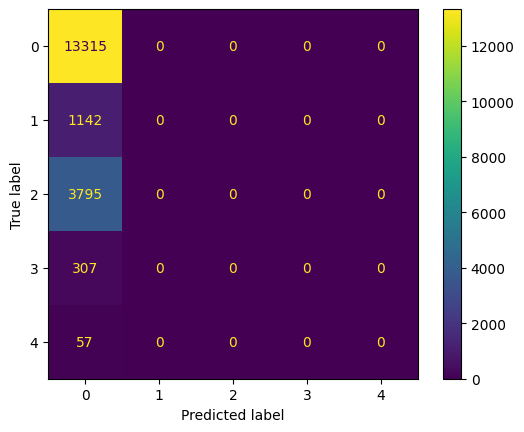

In [16]:
# Random Forest
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(
    rf, 
    param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}, 
    n_iter=5, 
    cv=5
)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

rand_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = rand_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Best hyperparameters: {'max_depth': 19, 'n_estimators': 242}
Accuracy: 0.35963687150837986


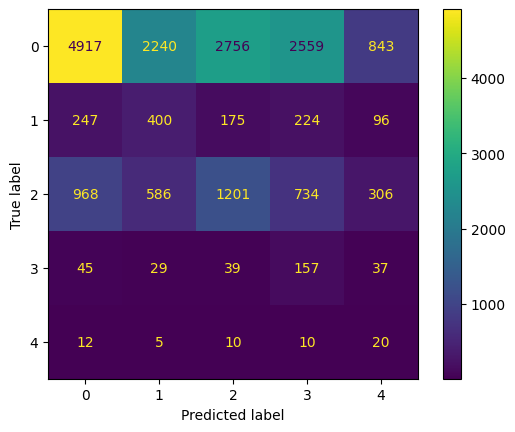

In [17]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.2, stratify=over_y)

# Retrain using SMOTE
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(
    rf, 
    param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}, 
    n_iter=5, 
    cv=5
)

rand_search.fit(over_X_train, over_y_train)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

SMOTE_SRF = RandomForestClassifier(
    n_estimators=rand_search.best_params_['n_estimators'],
    max_depth = rand_search.best_params_['max_depth'],
    random_state=0
)
#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(over_X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Accuracy: 0.5163432073544433


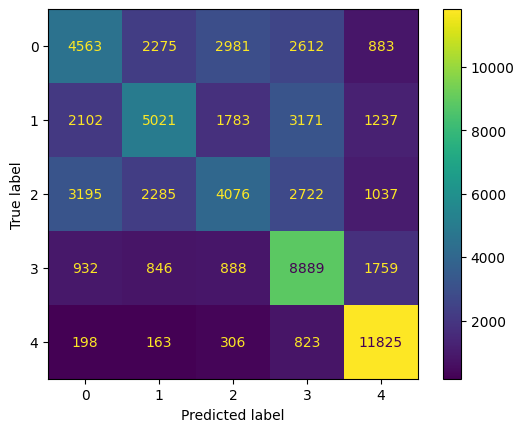

In [19]:
SMOTE_SRF = RandomForestClassifier(
    n_estimators=rand_search.best_params_['n_estimators'],
    max_depth = rand_search.best_params_['max_depth'],
    random_state=0
)
#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(over_X_test)

accuracy = accuracy_score(over_y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(over_y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();